In [1]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
import email.utils
import mailbox
from matplotlib import pyplot as plt
import os
import pandas as pd
import seaborn as sns
from typing import Dict, Tuple

# util functions

In [22]:
def all_mbox_files(mbox_folder: str) -> list:
        """
        Collect all mbox files from the given folder.
        
        Args:
            mbox_folder: Path to the folder containing mbox files
            
        Returns:
            List of paths to mbox files
        """
        mbox_files = []
        for year_folder in os.listdir(mbox_folder):
            year_path = os.path.join(mbox_folder, year_folder)
            if os.path.isdir(year_path):
                mbox_files.extend(
                    os.path.join(year_path, f) 
                    for f in os.listdir(year_path)
                )
        return mbox_files

In [2]:
def process_single_message(msg: mailbox.mboxMessage) -> dict:
    """
    Process a single email message and extract relevant information.
    
    Args:
        msg: An email message from the mbox file
        
    Returns:
        Dictionary containing message details
    """
    # Extract message ID
    msg_id = msg.get('Message-ID', '').strip().strip('<>')
    if not msg_id:
        return None
        
    # Extract date
    date_str = msg.get('Date')
    if date_str:
        try:
            # Parse the email date
            date_tuple = email.utils.parsedate_tz(date_str)
            if date_tuple:
                date = datetime(*date_tuple[:6])
                year = date.year
            else:
                return None
        except Exception:
            return None
    else:
        return None
        
    # Get References and In-Reply-To
    references = msg.get('References', '')
    in_reply_to = msg.get('In-Reply-To', '').strip().strip('<>')
    
    # Get all ancestors
    ancestors = set()
    if references:
        ancestors.update(ref.strip().strip('<>') for ref in references.split())
    if in_reply_to and in_reply_to not in ancestors:
        ancestors.add(in_reply_to)
    
    return {
        'message_id': msg_id,
        'year': year,
        'ancestors': ancestors
    }


In [3]:
def process_mbox_file(file_path: str) -> pd.DataFrame:
    """
    Process a single mbox file and return its data as a DataFrame.
    
    Args:
        file_path: Path to the mbox file
        
    Returns:
        DataFrame containing message information
    """
    try:
        mbox = mailbox.mbox(file_path)
        messages_data = []
        
        for message in mbox:
            msg_data = process_single_message(message)
            if msg_data:
                messages_data.append(msg_data)
        
        return pd.DataFrame(messages_data)
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on failure

In [4]:
def analyze_mbox_files(file_paths: list) -> Tuple[Dict[int, int], Dict[int, int]]:
    """
    Analyze multiple mbox files in parallel and generate thread and email counts by year.
    
    Args:
        file_paths: List of paths to mbox files
        
    Returns:
        Tuple of (threads_by_year, emails_by_year) dictionaries
    """
   
    
    # Process all mbox files in parallel
    with ThreadPoolExecutor() as executor:
        try:
            # Get DataFrames for all files
            dfs = list(executor.map(process_mbox_file, file_paths))
        except Exception as e:
            print(f"Error during parallel processing: {e}")
            dfs = []  # Return an empty list in case of error
    
    # Combine all DataFrames (ensure the result is not empty)
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
    else:
        combined_df = pd.DataFrame()  # Empty DataFrame if there's an error
    
    # Proceed with the rest of the logic only if combined_df is not empty
    if not combined_df.empty:
        all_messages = set(combined_df['message_id'])
        
        # Determine root messages
        def is_root(row):
            return not any(ancestor in all_messages for ancestor in row['ancestors'])
        
        # Add root column
        combined_df['is_root'] = combined_df.apply(is_root, axis=1)
        
        # Calculate threads by year
        threads_by_year = combined_df[combined_df['is_root']].groupby('year').size().to_dict()
        
        # Calculate total emails by year
        emails_by_year = combined_df.groupby('year').size().to_dict()
        
        return threads_by_year, emails_by_year
    else:
        print("No data to process.")
        return {}, {}

## plot visuasualizations

In [5]:
def plot_yearly_statistics(threads_by_year: Dict[int, int], emails_by_year: Dict[int, int]):
    """
    Create and display plots for yearly thread and email counts, with values shown on the bars.
    
    Args:
        threads_by_year: Dictionary of year to thread count
        emails_by_year: Dictionary of year to email count
    """
    # Set up the plotting style
    sns.set_style("whitegrid")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot thread counts
    thread_data = pd.DataFrame.from_dict(threads_by_year, orient='index', columns=['count'])
    thread_plot = sns.barplot(data=thread_data.reset_index(), x='index', y='count', ax=ax1, color='skyblue')
    ax1.set_title('Unique Threads by Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Threads')
    
    # Add values to the bars (Thread count)
    for p in thread_plot.patches:
        ax1.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     xytext=(0, 5),  # Offset label slightly
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=10, color='black')
    
    # Plot email counts
    email_data = pd.DataFrame.from_dict(emails_by_year, orient='index', columns=['count'])
    email_plot = sns.barplot(data=email_data.reset_index(), x='index', y='count', ax=ax2, color='lightgreen')
    ax2.set_title('Total Emails by Year')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Emails')
    
    # Add values to the bars (Email count)
    for p in email_plot.patches:
        ax2.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     xytext=(0, 5),  # Offset label slightly
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=10, color='black')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


# main

In [23]:
def main(mbox_folder: str) -> None:
    """Analyze email threads from mbox files with parallel processing."""

    # Collect all mbox files
    mbox_files = all_mbox_files(mbox_folder)
    threads_by_year, emails_by_year = analyze_mbox_files(mbox_files)
    
    print("\nThread counts by year:")
    for year, count in sorted(threads_by_year.items()):
        print(f"{year}: {count} threads")
        
    print("\nEmail counts by year:")
    for year, count in sorted(emails_by_year.items()):
        print(f"{year}: {count} emails")
    
    # Create visualizations
    plot_yearly_statistics(threads_by_year, emails_by_year)


Thread counts by year:
2020: 434 threads
2021: 424 threads
2022: 290 threads
2023: 400 threads
2024: 456 threads

Email counts by year:
2020: 1814 emails
2021: 1873 emails
2022: 1399 emails
2023: 1919 emails
2024: 2153 emails


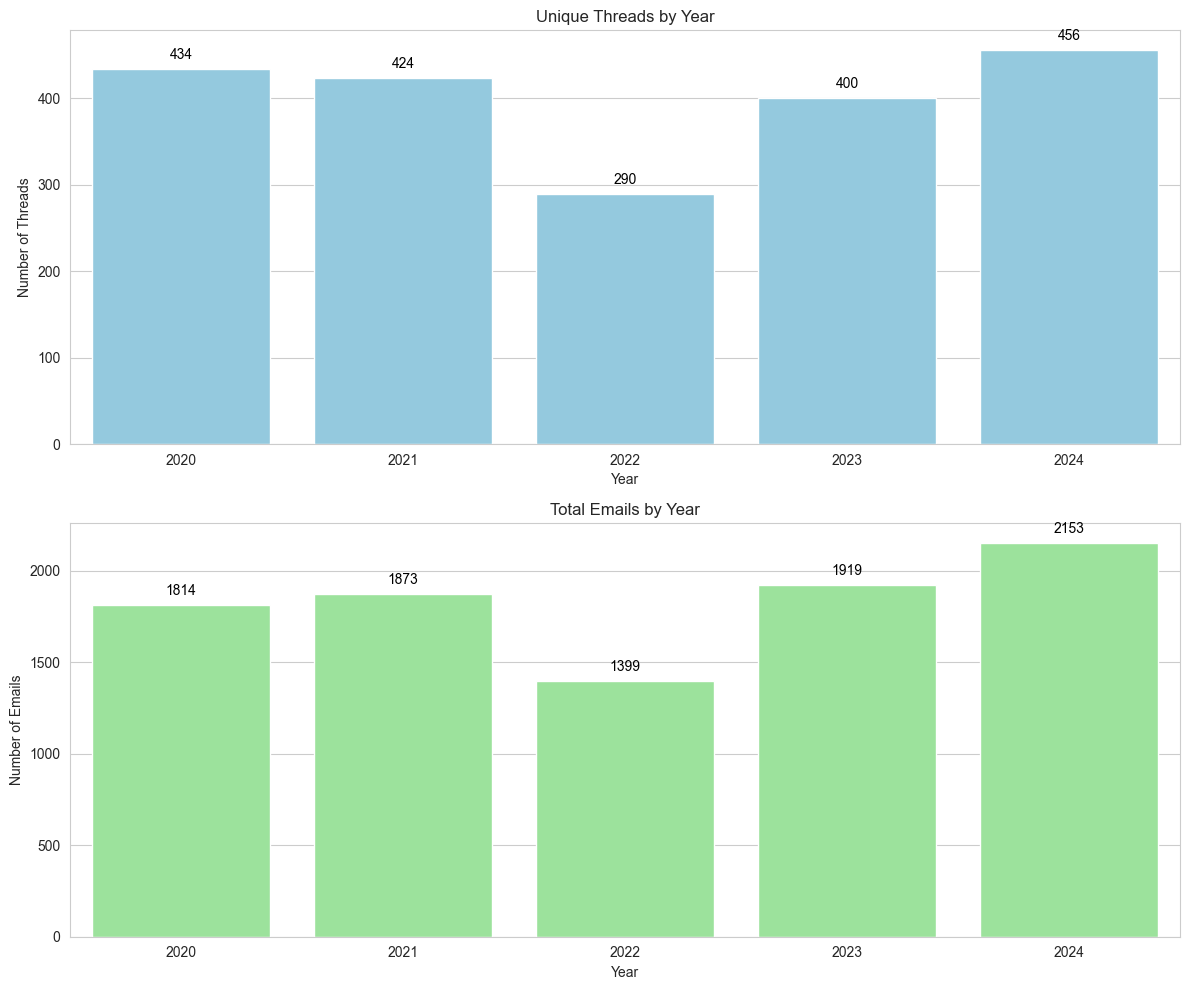

In [24]:
main(r'C:\Users\srika\HexaCluster\postgres_mailing_list-analysis\data\pgsql-admin')